In [1]:
import os
import random
import torch
from torch.utils.data import DataLoader, Subset
from PIL import Image
import clip
from tqdm import tqdm


In [2]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [12]:
from torch.utils.data import Dataset
from PIL import Image
import os
import xml.etree.ElementTree as ET

class CLIPChestXrayDataset(Dataset):
    def __init__(self, image_dir, report_dir, preprocess, tokenizer, max_length=77):
        self.image_dir = image_dir
        self.report_dir = report_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.samples = []
        for report_file in os.listdir(report_dir):
            if not report_file.endswith(".xml"):
                continue

            report_path = os.path.join(report_dir, report_file)
            tree = ET.parse(report_path)
            root = tree.getroot()

            # Extract text (impression first, then findings)
            impression, findings = "", ""
            for child in root.findall(".//AbstractText"):
                label = child.get("Label", "").lower()
                if "impression" in label:
                    impression = child.text or ""
                elif "findings" in label:
                    findings = child.text or ""

            combined_text = (impression + " " + findings).replace("XXXX", "").strip()
            if not combined_text:
                continue

            # Find associated images
            for img_tag in root.findall(".//parentImage"):
                image_name = img_tag.get("id") + ".png"
                image_path = os.path.join(image_dir, image_name)
                if os.path.exists(image_path):
                    self.samples.append((image_path, combined_text))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, text = self.samples[idx]
        image = self.preprocess(Image.open(image_path).convert("RGB"))
        tokenized_text = self.tokenizer([text], truncate=True)[0]
        return image, tokenized_text, text  # Return raw text here too


In [16]:
# Full dataset first
full_dataset = CLIPChestXrayDataset(
    image_dir="C://Users//2003j//Downloads//into_to_ml//chest_reports//split_data//train//images",
    report_dir="C://Users//2003j//Downloads//into_to_ml//chest_reports//split_data//train//reports",
    preprocess=preprocess,
    tokenizer=clip.tokenize
)

# Small subset (e.g., 10%)
subset_size = int(0.1 * len(full_dataset))
indices = random.sample(range(len(full_dataset)), subset_size)
small_dataset = Subset(full_dataset, indices)

train_loader = DataLoader(small_dataset, batch_size=16, shuffle=True)


In [5]:
import torch.nn.functional as F

def train_clip_model(model, dataloader, device, epochs=1, lr=5e-6):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0.0
        for images, texts in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            images = images.to(device)
            texts = texts.to(device)

            image_features = model.encode_image(images)
            text_features = model.encode_text(texts)

            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            text_features = text_features / text_features.norm(dim=1, keepdim=True)

            logits = image_features @ text_features.T
            labels = torch.arange(len(images)).to(device)
            loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")


In [6]:
train_clip_model(model, train_loader, device, epochs=1)


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 38/38 [04:11<00:00,  6.61s/it]


✅ Epoch 1 completed. Avg Loss: 2.6966


In [7]:
torch.save(model.state_dict(), "clip_finetuned_subset.pth")


In [22]:
def inspect_clip_predictions(model, test_loader, device, num_samples=5):
    model.eval()
    print("🔍 Inspecting predictions on sample test images...\n")

    samples_checked = 0
    for image, tokenized_text, raw_text in test_loader:
        if samples_checked >= num_samples:
            break

        image = image.to(device)
        tokenized_text = tokenized_text.to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(tokenized_text)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarity = (image_features @ text_features.T).squeeze(0)

        print(f"🖼 Image {samples_checked+1}:")
        print(f"🔗 Similarity Score: {similarity.item():.4f}")
        print(f"📄 Report: {raw_text[0][:300]}")  # Only print first 300 chars
        print("-" * 60)

        samples_checked += 1


In [23]:
test_dataset = CLIPChestXrayDataset(
    image_dir="C://Users//2003j//Downloads//into_to_ml//chest_reports//split_data//test//images",
    report_dir="C://Users//2003j//Downloads//into_to_ml//chest_reports//split_data//test//reports",
    preprocess=preprocess,
    tokenizer=clip.tokenize
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inspect_clip_predictions(model, test_loader, device, num_samples=5)


🔍 Inspecting predictions on sample test images...

🖼 Image 1:
🔗 Similarity Score: 0.2427
📄 Report: No active disease. Both lungs are clear and expanded. Heart and mediastinum normal.
------------------------------------------------------------
🖼 Image 2:
🔗 Similarity Score: 0.2507
📄 Report: No active disease. Both lungs are clear and expanded. Heart and mediastinum normal.
------------------------------------------------------------
🖼 Image 3:
🔗 Similarity Score: 0.2895
📄 Report: No acute findings. Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.
------------------------------------------------------------
🖼 Image 4:
🔗 Similarity Score: 0.2728
📄 Report: No acute findings. Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.
------------------------------------------------------------
🖼 Image 5:
🔗 Similarity Score: 0.2728
📄 Report: 1. Mild stable cardiomegaly and central vas

In [42]:
import torch
from tqdm import tqdm

def evaluate_clip_model_topk_safe(model, test_loader, device, k=3):
    model.eval()
    image_features_list = []
    text_features_list = []

    print("🔍 Encoding all reports...")
    for batch in tqdm(test_loader):
        # Unpack the correct items
        images = batch[0].to(device)
        tokenized_text = batch[2].to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            text_features = model.encode_text(tokenized_text)

            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            image_features_list.append(image_features)
            text_features_list.append(text_features)

    image_features_all = torch.cat(image_features_list, dim=0)
    text_features_all = torch.cat(text_features_list, dim=0)

    print("🧠 Calculating Top-k matches...")
    total = image_features_all.size(0)
    correct_top1 = 0
    correct_topk = 0

    similarity_matrix = image_features_all @ text_features_all.T  # [N, N]

    for i in range(total):
        topk_indices = similarity_matrix[i].topk(k).indices
        if i == topk_indices[0]:
            correct_top1 += 1
        if i in topk_indices:
            correct_topk += 1

    print(f"\n📊 Evaluation Complete on {total} Samples")
    print(f"🎯 Top-1 Accuracy: {correct_top1 / total:.2f}")
    print(f"🔁 Top-{k} Accuracy: {correct_topk / total:.2f}")


In [47]:
import random
from PIL import Image
import torch
from tqdm import tqdm

def manually_verify_predictions(model, dataset, device, num_samples=2):
    model.eval()
    sampled_indices = random.sample(range(len(dataset)), num_samples)

    for idx in sampled_indices:
        # Get sample
        image_tensor, tokenized_text, raw_text = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)

        # Get all reports (tokenized + raw)
        all_tokenized = torch.stack([dataset[i][1] for i in range(len(dataset))]).to(device)
        all_raw_texts = [dataset[i][2] for i in range(len(dataset))]

        # Encode features
        with torch.no_grad():
            image_features = model.encode_image(image_tensor)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            text_features = model.encode_text(all_tokenized)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            similarity = (image_features @ text_features.T).squeeze(0)
            best_idx = similarity.argmax().item()

        # Show result
        print("🖼 Image Index:", idx)
        print("📌 Predicted Matching Report Index:", best_idx)
        print("📄 Predicted Report:\n", all_raw_texts[best_idx][:500])
        print("🧾 Actual Report:\n", raw_text[:500])
        print(f"📈 Similarity Score: {similarity[best_idx].item():.4f}")
        print("=" * 80)

# Run the function
manually_verify_predictions(model, test_dataset, device, num_samples=2)


🖼 Image Index: 655
📌 Predicted Matching Report Index: 116
📄 Predicted Report:
 1. No acute radiographic cardiopulmonary process. Three images are available for review. The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The  are grossly normal. There is no visible free intraperitoneal air under the diaphragm.
🧾 Actual Report:
 1. No interval change in the appearance of the  opacities in the bilateral lower lobes. The cardiomediastinal silhouette is within normal limits for appearance. No focal areas of pulmonary consolidation. No interval change in the appearance of the  opacities in the bilateral lower lobes. No pneumothorax. No pleural effusion. The thoracic spine appears intact.
📈 Similarity Score: 0.3496
🖼 Image Index: 605
📌 Predicted Matching Report Index: 172
📄 Predicted Report:
 Heart size is normal and lungs are clear.
🧾 Actual R

In [59]:
def inspect_true_predictions_from_pool(model, test_dataset, device, num_samples=5):
    from tqdm import tqdm
    model.eval()
    print("🔍 Matching test images to full report pool...")

    valid_reports = []
    valid_tokenized = []

    # Safely tokenize each report
    for _, _, report in tqdm(test_dataset):
        try:
            tokens = clip.tokenize([report])
            valid_tokenized.append(tokens)
            valid_reports.append(report)
        except RuntimeError:
            continue  # Skip if too long

    if len(valid_reports) == 0:
        print("❌ No valid reports available within token limit.")
        return

    all_tokenized = torch.cat(valid_tokenized).to(device)

    with torch.no_grad():
        all_text_features = model.encode_text(all_tokenized)
        all_text_features = all_text_features / all_text_features.norm(dim=-1, keepdim=True)

    # Pick test samples
    indices = torch.randperm(len(test_dataset))[:num_samples]

    for i, idx in enumerate(indices):
        image, _, ground_truth = test_dataset[idx]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            image_feature = model.encode_image(image)
            image_feature = image_feature / image_feature.norm(dim=-1, keepdim=True)

            similarity = image_feature @ all_text_features.T
            top_idx = similarity.argmax().item()
            score = similarity[0, top_idx].item()

        print(f"\n🖼 Sample {i+1}")
        print(f"🔗 Similarity Score: {score:.4f}")
        print("📄 Ground Truth Report:")
        print(f"{ground_truth[:400]}")
        print("🧠 Predicted Top-1 Report:")
        print(f"{valid_reports[top_idx][:400]}")
        print("-" * 60)




In [60]:
inspect_true_predictions_from_pool(model, test_dataset, device, num_samples=5)


🔍 Matching test images to full report pool...


100%|████████████████████████████████████████████████████████████████████████████████| 743/743 [00:10<00:00, 71.70it/s]



🖼 Sample 1
🔗 Similarity Score: 0.3317
📄 Ground Truth Report:
Low lung volumes. No acute cardiopulmonary abnormalities. Normal cardiomediastinal contours, given patient position and technique. No pneumothorax or large pleural effusions. The lung volumes.
🧠 Predicted Top-1 Report:
1. No evidence of active disease. The heart size and pulmonary vascularity appear within normal limits. Vascular calcification is identified. Calcified granuloma is present in the right lower lobe. No  nodules are seen. No pneumothorax or pleural effusion is seen. No focal airspace disease is identified.
------------------------------------------------------------

🖼 Sample 2
🔗 Similarity Score: 0.3139
📄 Ground Truth Report:
No acute cardiopulmonary process. . The cardiomediastinal silhouette is within normal limits for appearance. No focal areas of pulmonary consolidation. No pneumothorax. No pleural effusion. Mild degenerative changes of the thoracic spine.
🧠 Predicted Top-1 Report:
Heart size is normal and 

In [8]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model = model.to(device)


In [9]:
model.load_state_dict(torch.load("clip_finetuned_subset.pth"))
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((7

In [13]:
from torch.utils.data import DataLoader

# Assuming you already have your custom dataset class
test_dataset = CLIPChestXrayDataset(
    image_dir="C:/Users/2003j/Downloads/into_to_ml/chest_reports/split_data/test/images",
    report_dir="C:/Users/2003j/Downloads/into_to_ml/chest_reports/split_data/test/reports",
    preprocess=preprocess,
    tokenizer=clip.tokenize
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # you can adjust batch_size


In [14]:
import torch

def extract_image_features(model, dataloader, device):
    model.eval()
    image_features = []
    labels = []

    with torch.no_grad():
        for images, tokenized_texts, raw_texts in dataloader:
            images = images.to(device)
            features = model.encode_image(images)
            features = features / features.norm(dim=-1, keepdim=True)
            image_features.append(features.cpu())

    image_features = torch.cat(image_features, dim=0)
    return image_features.numpy()

# Extract features
image_features = extract_image_features(model, test_loader, device)


In [6]:
def plot_tsne(image_features, labels_list):
    print("🎨 Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=3000)
    features_2d = tsne.fit_transform(image_features)

    plt.figure(figsize=(10, 7))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c='blue', alpha=0.6, s=10)
    plt.title("t-SNE Visualization of Chest X-ray Features (CLIP)")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.grid(True)
    plt.savefig("tsne_chest_xray.png", dpi=300)  # Save figure
    plt.show()

    print("✅ t-SNE plot saved as 'tsne_chest_xray.png'!")


In [16]:
labels_list = []
for _, _, report_text in test_dataset:
    if "pneumothorax" in report_text.lower() or "effusion" in report_text.lower():
        labels_list.append(1)  # Disease
    else:
        labels_list.append(0)  # Normal


🎨 Running t-SNE...


C:\Users\2003j\anaconda3\envs\clip_env1\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\2003j\anaconda3\envs\clip_env1\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\2003j\anaconda3\envs\clip_env1\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\2003j\anaconda3\envs\clip_env1\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\2003j\anaconda3\envs\clip_env1\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.Cre

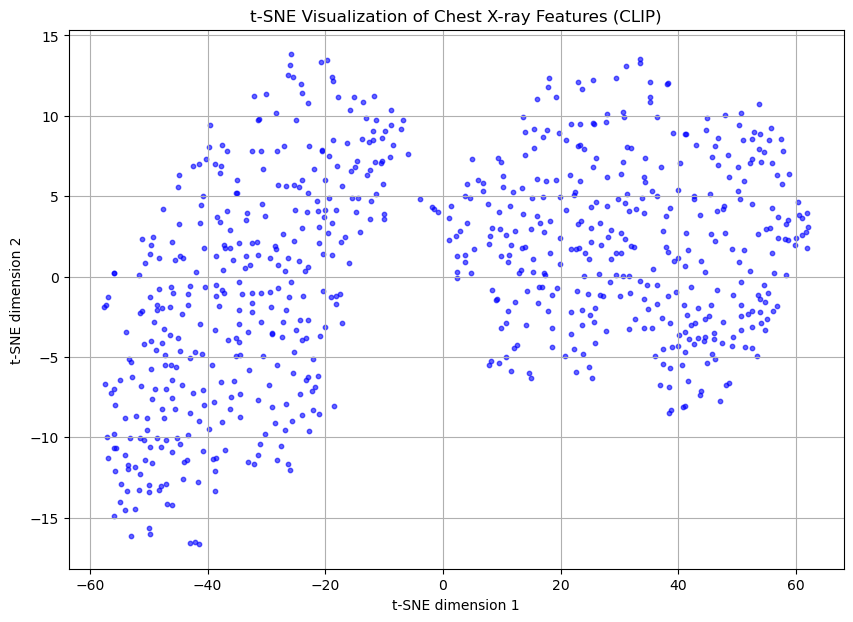

✅ t-SNE plot saved as 'tsne_chest_xray.png'!


In [17]:
plot_tsne(image_features, labels_list)


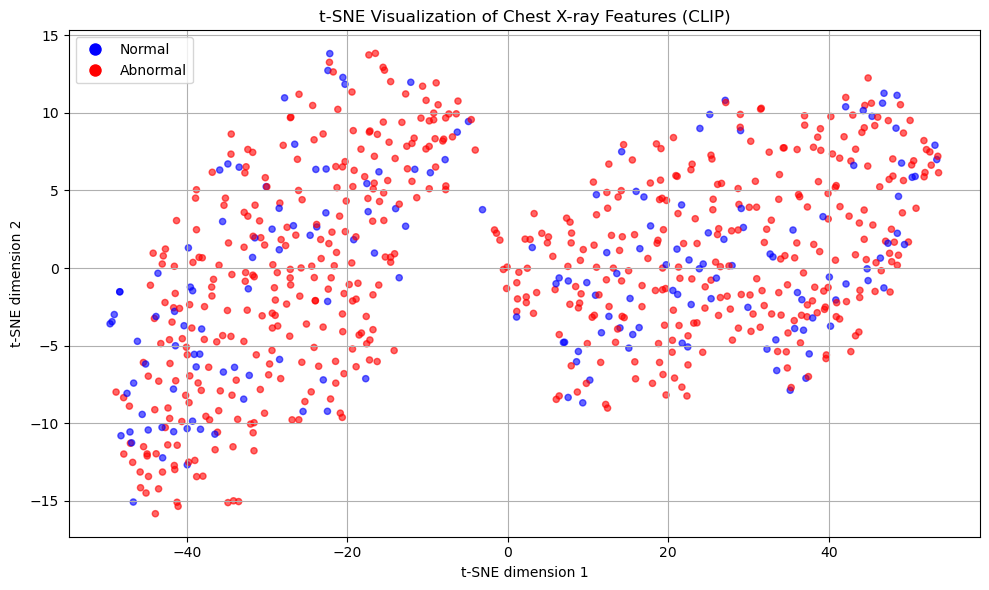

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you already have image_features (as numpy array)

# Use keyword-matching to tag basic labels
labels_list = []
for _, _, report_text in test_dataset:
    if "pneumonia" in report_text.lower() or "effusion" in report_text.lower():
        labels_list.append("Abnormal")
    else:
        labels_list.append("Normal")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(image_features)

# Convert labels to colors
colors = ["red" if l == "Abnormal" else "blue" for l in labels_list]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=colors, alpha=0.6, s=20)
plt.title("t-SNE Visualization of Chest X-ray Features (CLIP)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Abnormal', markerfacecolor='red', markersize=10)
])
plt.grid(True)
plt.tight_layout()
plt.show()
